# Importing TensorFlow

In [1]:
!nvidia-smi

Wed Jun 19 12:36:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   58C    P5             14W /  100W |      14MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [3]:
import tensorflow as tf
print(tf.__version__)

2024-06-19 12:36:34.874961: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 12:36:34.900096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 12:36:34.900113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 12:36:34.900718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 12:36:34.905024: I tensorflow/core/platform/cpu_feature_guar

2.15.0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras
import tensorflow_datasets as tfds

# Preparing data

In [5]:
(train_data, val_data, test_data), ds_info = tfds.load(
    "beans",
    split = ["train", "validation", "test"],
    as_supervised = True,
    shuffle_files = True,
    with_info = True    
)

2024-06-19 12:36:36.879679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6070 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(500, 500, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
})

In [7]:
class_names = ds_info.features["label"].names
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [8]:
sample_img = test_data.take(1)
for image, label in sample_img:
    print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class: {label}
    Class name: {class_names[label.numpy()]}
    """)


    Image shape: (500, 500, 3)
    Image dtype: <dtype: 'uint8'>
    Target class: 0
    Class name: angular_leaf_spot
    


2024-06-19 12:36:37.071924: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

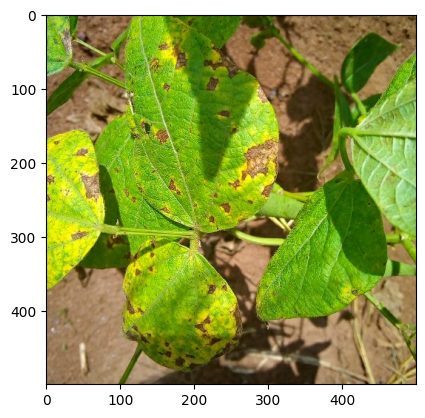

In [10]:
plt.imshow(image)

In [11]:
data_aug_layers = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

train_data_aug = train_data.map(lambda x, y: (data_aug_layers(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
def preprocess_img(image, label, img_shape=500, rescale=False):
    image = tf.image.resize(image, [img_shape, img_shape])
    if rescale==False:
        return tf.cast(image, tf.float32), label
    else:
        return tf.cast(image, tf.float32)/255., label

In [13]:
train_dataset = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset_aug = train_data_aug.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE),
val_dataset = val_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoint/cp.weights.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

In [15]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


# Creating and training cnn model

In [16]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[500,500,3]),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, 1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(32, 3, 1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(64, 3, 1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(128, 3, 1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(256, 3, 1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [17]:
cnn_model.compile(
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [18]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 250, 250, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 125, 125, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 64)     

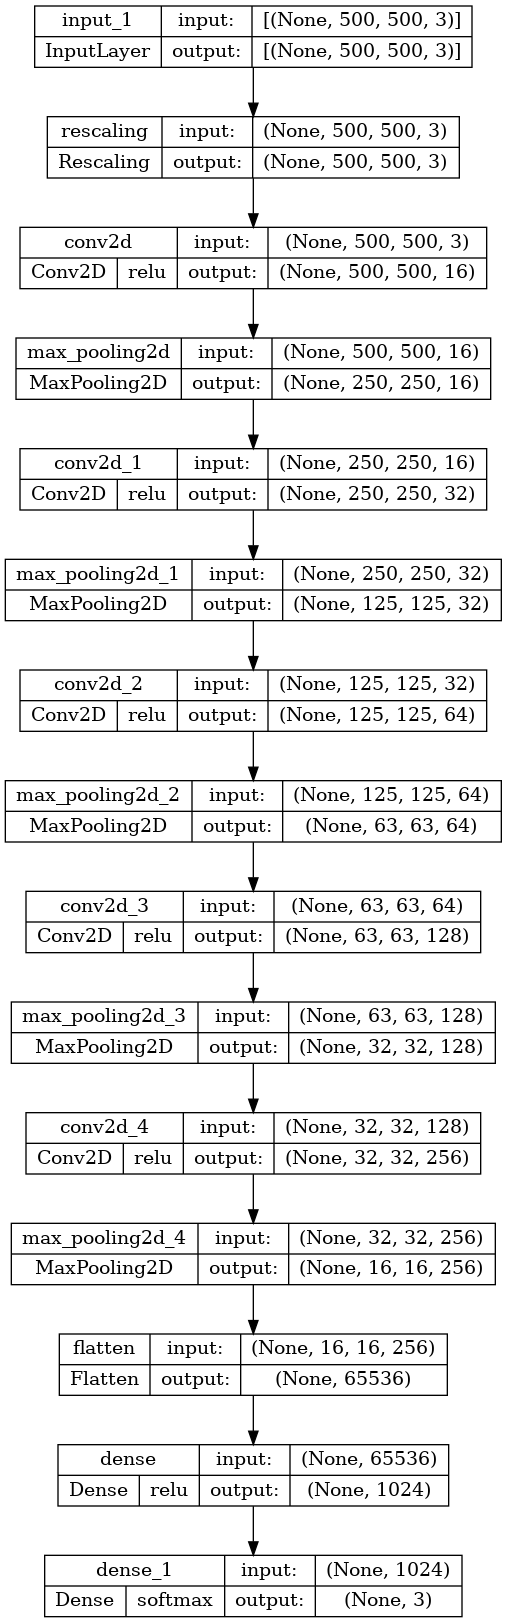

In [19]:
tf.keras.utils.plot_model(cnn_model, show_layer_activations=True, show_shapes=True)

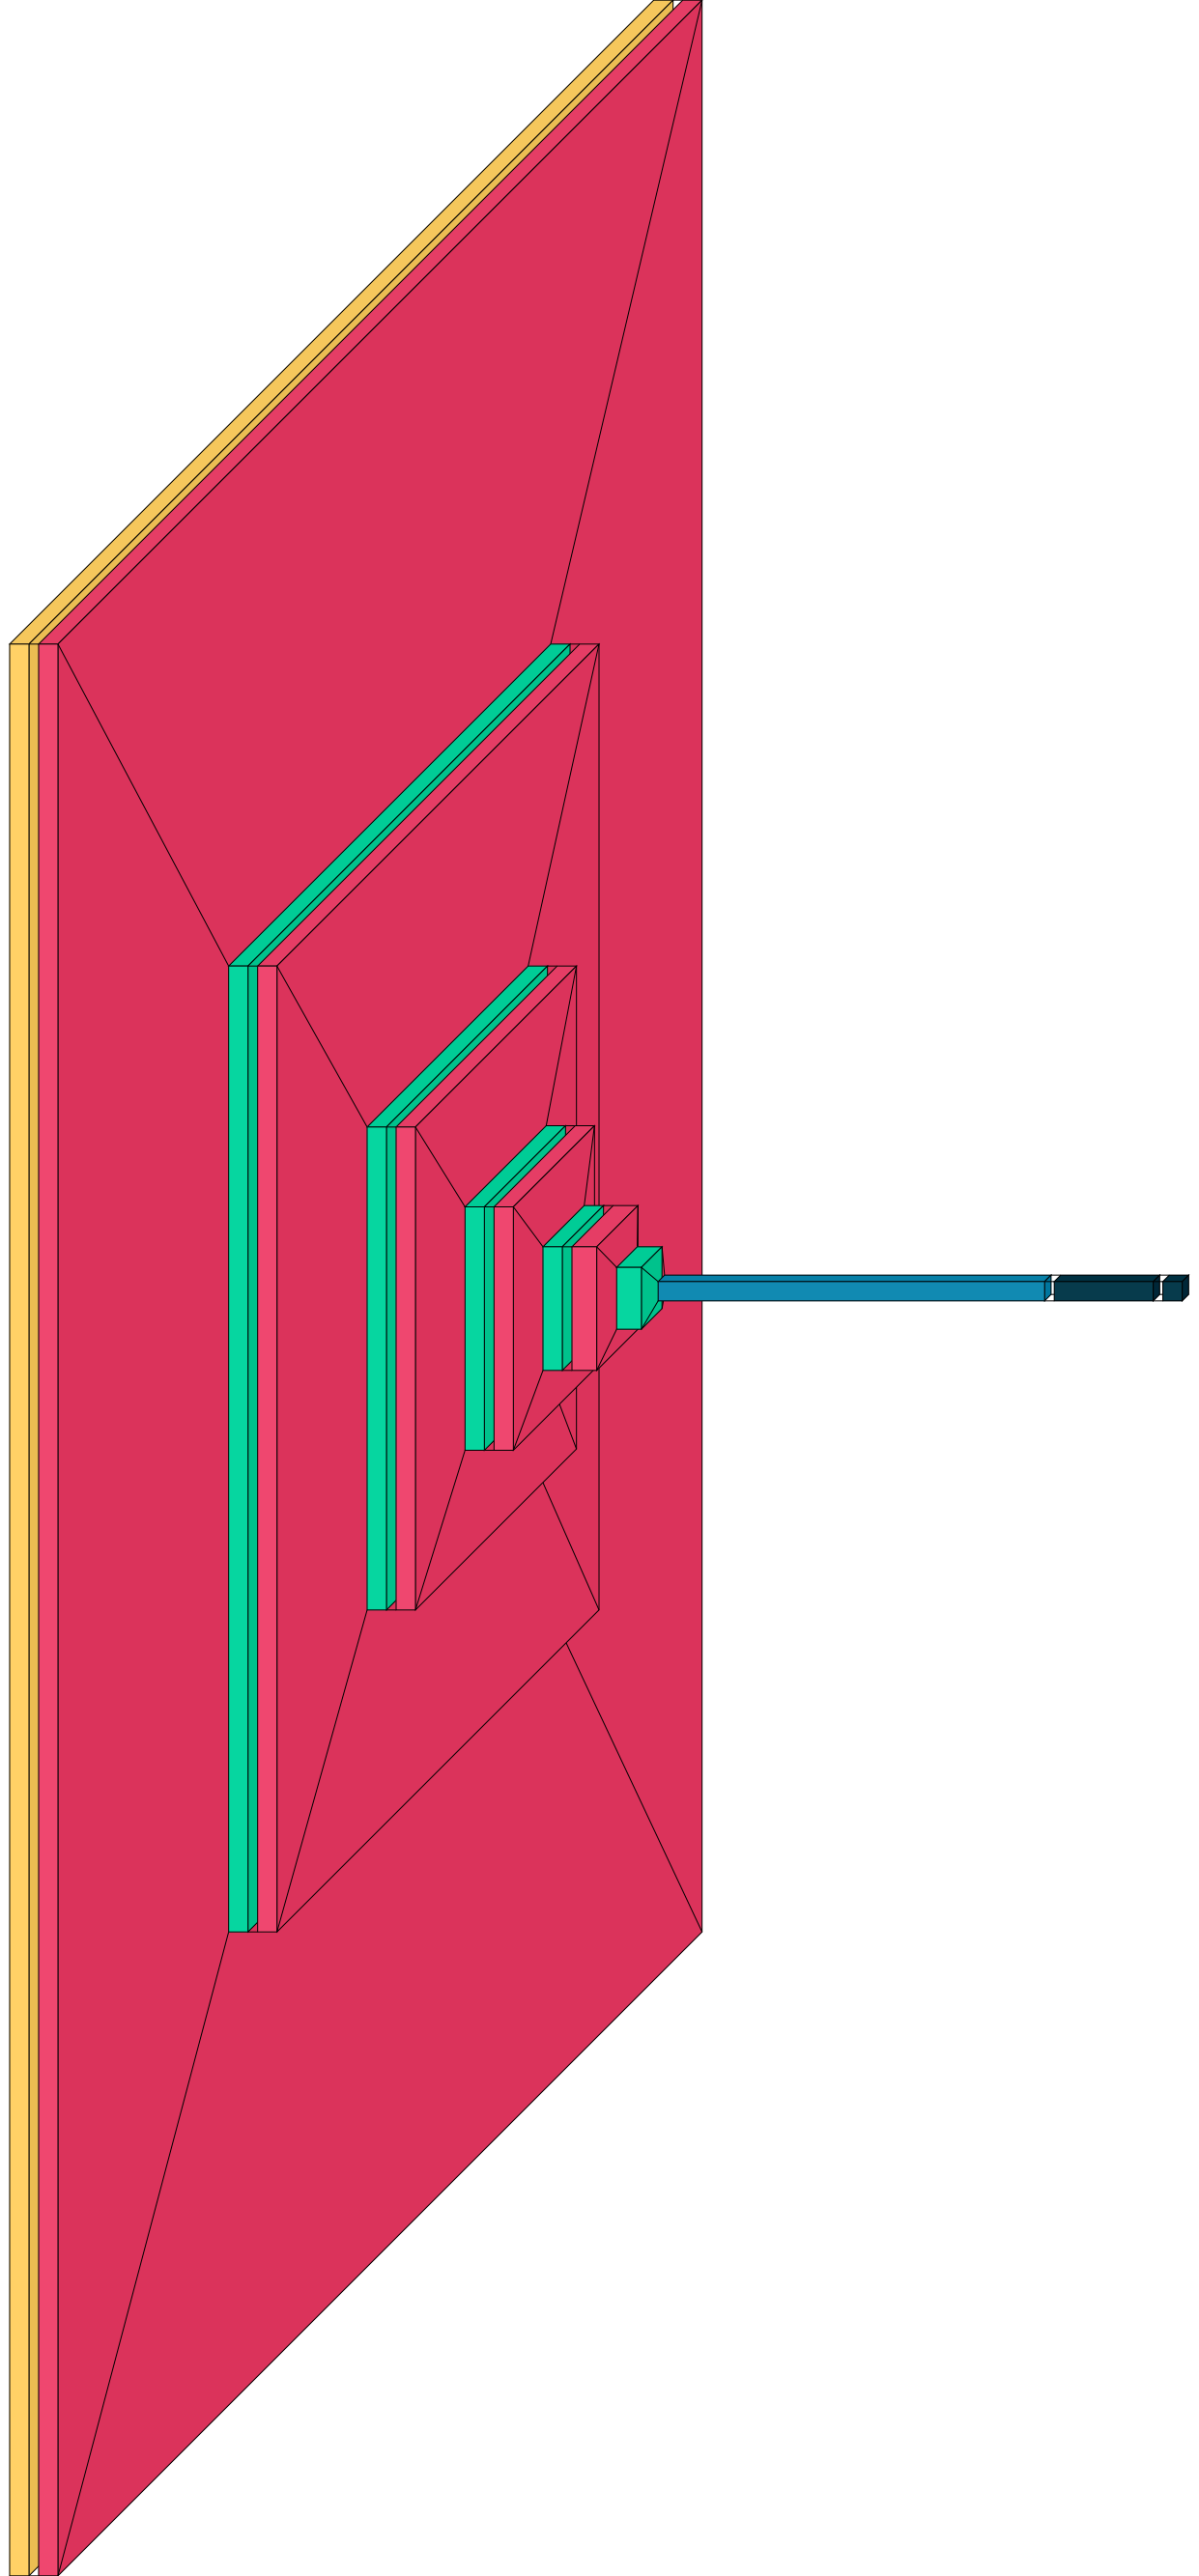

In [20]:
visualkeras.layered_view(cnn_model)

In [21]:
cnn_history = cnn_model.fit(
    x = train_dataset,
    validation_data = val_dataset,
    epochs = 20,
    callbacks = [model_checkpoint]
)

Epoch 1/20


2024-06-19 12:36:38.872396: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-19 12:36:38.936775: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-19 12:36:39.013373: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-19 12:36:46.076255: I external/local_xla/xla/service/service.cc:168] XLA service 0x746204003970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-19 12:36:46.076282: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-06-19 12:36:46.085989: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718789806.143827   27970 devic

33/33 [==============================] - 17s 254ms/step - loss: 2.5402 - accuracy: 0.4246 - val_loss: 0.9073 - val_accuracy: 0.6090
Epoch 2/20
33/33 [==============================] - 5s 138ms/step - loss: 0.8499 - accuracy: 0.6151 - val_loss: 0.7913 - val_accuracy: 0.6241
Epoch 3/20
33/33 [==============================] - 5s 139ms/step - loss: 0.8022 - accuracy: 0.6335 - val_loss: 0.6729 - val_accuracy: 0.7068
Epoch 4/20
33/33 [==============================] - 3s 86ms/step - loss: 0.6945 - accuracy: 0.6983 - val_loss: 0.6476 - val_accuracy: 0.6992
Epoch 5/20
33/33 [==============================] - 3s 86ms/step - loss: 0.6837 - accuracy: 0.7137 - val_loss: 0.6333 - val_accuracy: 0.7068
Epoch 6/20
33/33 [==============================] - 3s 85ms/step - loss: 0.6068 - accuracy: 0.7476 - val_loss: 0.7371 - val_accuracy: 0.6842
Epoch 7/20
33/33 [==============================] - 4s 137ms/step - loss: 0.5598 - accuracy: 0.7631 - val_loss: 0.6001 - val_accuracy: 0.7368
Epoch 8/20
33/33 [=

<Axes: >

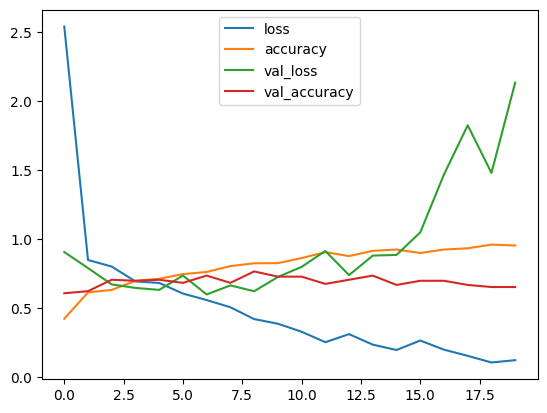

In [22]:
pd.DataFrame(cnn_history.history).plot()

# Creating and training efficientnet model

In [23]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=[500,500,3])
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

efficientnet_model = tf.keras.models.Model(inputs, outputs)

In [24]:
efficientnet_model.compile(
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [25]:
efficientnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 efficientnetb3 (Functional  (None, None, None, 1536   10783535  
 )                           )                                   
                                                                 
 global_max_pooling2d (Glob  (None, 1536)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense_2 (Dense)             (None, 3)                 4611      
                                                                 
Total params: 10788146 (41.15 MB)
Trainable params: 4611 (18.01 KB)
Non-trainable params: 10783535 (41.14 MB)
_________________________________________________________________


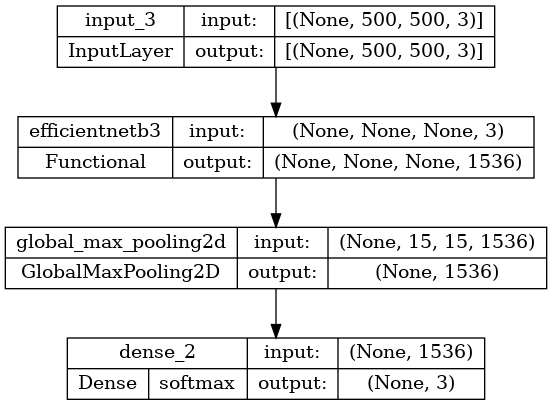

In [26]:
tf.keras.utils.plot_model(efficientnet_model, show_layer_activations=True, show_shapes=True)

In [27]:
efficientnet_history = efficientnet_model.fit(
    x = train_dataset,
    validation_data = val_dataset,
    epochs = 10,
    callbacks = [model_checkpoint]
)

Epoch 1/10
33/33 [==============================] - 16s 307ms/step - loss: 2.2450 - accuracy: 0.4874 - val_loss: 1.0216 - val_accuracy: 0.6917
Epoch 2/10
33/33 [==============================] - 9s 270ms/step - loss: 0.8746 - accuracy: 0.7137 - val_loss: 0.6200 - val_accuracy: 0.7970
Epoch 3/10
33/33 [==============================] - 9s 272ms/step - loss: 0.6058 - accuracy: 0.7756 - val_loss: 0.5083 - val_accuracy: 0.8120
Epoch 4/10
33/33 [==============================] - 8s 247ms/step - loss: 0.5529 - accuracy: 0.8066 - val_loss: 0.5465 - val_accuracy: 0.8120
Epoch 5/10
33/33 [==============================] - 9s 266ms/step - loss: 0.4058 - accuracy: 0.8569 - val_loss: 0.4504 - val_accuracy: 0.8271
Epoch 6/10
33/33 [==============================] - 9s 268ms/step - loss: 0.3352 - accuracy: 0.8830 - val_loss: 0.3744 - val_accuracy: 0.8496
Epoch 7/10
33/33 [==============================] - 8s 248ms/step - loss: 0.2644 - accuracy: 0.9072 - val_loss: 0.3994 - val_accuracy: 0.8421
Epoch

<Axes: >

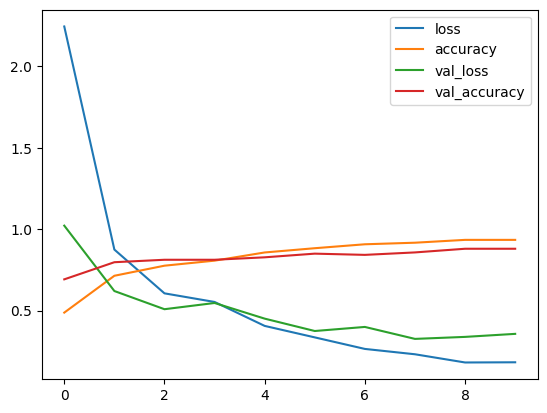

In [28]:
pd.DataFrame(efficientnet_history.history).plot()

# Model comp. and summary

In [29]:
print(f"cnn_model:")
cnn_model.evaluate(test_dataset)
print(f"\nefficientnet_model:")
efficientnet_model.evaluate(test_dataset)

cnn_model:
4/4 [==============================] - 0s 23ms/step - loss: 1.4775 - accuracy: 0.7500

efficientnet_model:
4/4 [==============================] - 1s 218ms/step - loss: 0.5424 - accuracy: 0.8359


[0.54241943359375, 0.8359375]

For test dataset; efficientnet model performed better on both accuracy and time efficiency